<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

## Objectives

In this notebook we are going to focus on two objectives:

- Understand Deep Convolutional Generative Adversarial Networks (DCGANs and GANs)

- Design and train DCGANs using the Keras API in Python

By the end, we will have built and trained a Deep Convolutional GAN (DCGAN) with Keras to generate images of fashionable clothes.

## Structure

The hands on project on Generating Synthetic Images with DCGANs in Kerasis divided into following tasks:

- Task 1: Project Overview and Import Libraries
- Task 2:  Load and Preprocess the Data
- Task 3: Create Batches of Training Data
- Task 4: Build the Generator Network for DCGAN
- Task 5: Build the Discriminator Network for DCGAN
- Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)
- Task 7: Define the Training Procedure
- Task 8: Train DCGAN
- Task 9: Generate Synthetic Images with DCGAN

## Task 1: Project Overview and Import Libraries

In [3]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.16.1


In [22]:
import plot_utils

## Task 2: Load and Preprocess the Data

In [4]:
# loading de data:
[x_train, y_train], [x_test, y_test] = tf.keras.datasets.fashion_mnist.load_data()

#preprocessing:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 24s 1us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 50us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 4s 1us/step


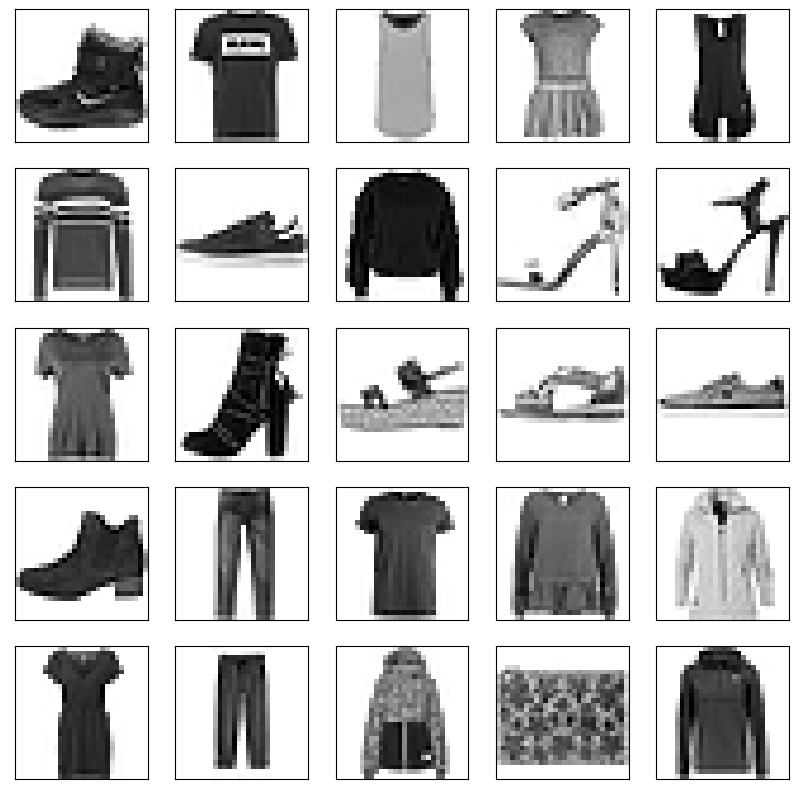

In [7]:
# Creating a 5x5 grid so we can see some images from the dataset:

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary) #tells matplotlib to use grayscale.
plt.show()

## Task 3: Create Batches of Training Data

In [8]:
# Creating a batch size, something manageable 
batch_size = 32

# Creating a dataset using x_train & tf.Dataset
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)


2024-04-24 16:16:51.736603: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


What this dataset is doing is filling a buffer with a thousand elements and then randomly sampling the elements from this buffer, then replacing these selected elements with the new ones.

In [9]:
# Now, let's combine consecutive elements from this dataset into batches:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

What we just done was: we created a dataset that filled a buffer with buffer size elements (1000), randomly sampled the elements,replacing these selected elements with the new ones, and lastly we combine the consecutive elements of this dataset into batches and also we are pre-fetching elements from this dataset.

## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [12]:
# setting the number of features:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape = [num_features]), # number of units - relatively small DCGAN
    keras.layers.Reshape([7, 7, 128]), # making sure the layers are reshaped to the particular size we selected
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5),(2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5),(2,2), padding='same', activation='tanh')
])


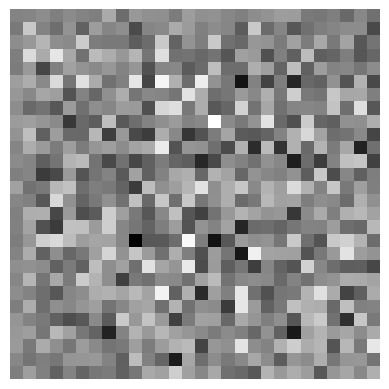

In [25]:
# create a seed, or a vector of random noise, that is gonna be passed through the generator:

noise = tf.random.normal(shape=[1,num_features])
generated_image = generator(noise, training=False)

# Assuming generated_image is a NumPy array

plt.imshow(generated_image[0, :, :, 0], cmap='gray')  # Assuming grayscale image
plt.axis('off')
plt.show()

## Task 5: Build the Discriminator Network for DCGAN

In [28]:
# the discriminator is simplt a CNN based image classifier
# in our case, a binary image classifier

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(1, activation='sigmoid')
    
])

In [29]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49734446]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [30]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False

gan = keras. models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer='rmsprop')

We set that the discriminator is not trainable, because first when we combine the generator and discriminator do create our DCGAN we first gonna train just the generator, we don´t want the discriminator to be trained at the time. 

## Task 7: Define Training Procedure

Creating a seed of random Gaussian noise: while is training we are going to track the process of the seed image and see how it evolves and hopefully improves over the various epochs we are training.

In [31]:
seed = tf.random.normal(shape=[batch_size, 100])

First we gonna train the discriminator network a bit, and then train the generator network.

The key steps: 
- we are going do sampling in mini-batches of noise samples from our Gaussian noise prior, and then also sampling in mini-batches of real images from our training data; 
- then we are going to pass the noise to our generator and get the fake images out;
- then we gonna have a mini-batch of both fake images and a mini-batch of real images. 
- then we gonna pick a gradient step on the discriminator using this mini-batch of fake and real images and then update the discriminator parameter.

In [35]:
def train_dcgan(gan, dataset,batch_size, num_features, epochs=5):
    generator, discriminator, = gan.layers
    for epoch in tqdm(range(epochs)):
        print('Epochs {}/{}'.format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # y1 is storing the class labels; a vector labeling the fake and real images
            discriminatortrainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    

In [36]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Task 8: Train DCGAN

In [38]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. -1.

In [40]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


2024-04-24 17:58:00.802497: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [42]:
%%time
train_dcgan(gan, dataset,batch_size,num_features, epochs=5)


  0%|                                                     | 0/5 [00:00<?, ?it/s]2024-04-24 17:59:21.752593: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epochs 1/5


/home/lorena/.pyenv/versions/personal_projects/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


  0%|                                                     | 0/5 [03:23<?, ?it/s]


KeyboardInterrupt: 

## Task 9: Generate Synthetic Images with DCGAN

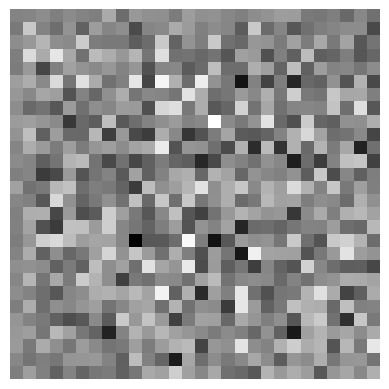

In [43]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')  # Assuming grayscale image
plt.axis('off')
plt.show()

In [44]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)

NameError: name 'filename' is not defined